In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import HydroErr

from matplotlib import pyplot as plt

import HydroErr

c:\Users\User\Anaconda3\envs\pytorch1.13\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 671

# training hyperparameters
EPOCHS = 500
TRAIN_YEAR = 9
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
study = joblib.load("data/camels_lstm_study.pkl")

In [4]:
dtrain_val = dataloader.Forcing_Data(
    "data/all_camels_train_val.csv",
    record_length=3652,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtrain = dataloader.Forcing_Data(
    "data/all_camels_train.csv",
    record_length=2922,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dval = dataloader.Forcing_Data(
    "data/all_camels_val.csv",
    record_length=1095,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtest = dataloader.Forcing_Data(
    "data/all_camels_test.csv",
    record_length=4383,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [5]:
def get_optimal_epochs(study):
    
    stats = study.best_trials[0].intermediate_values
    epochs = min(stats, key=lambda k: stats[k]) + 1
    
    return epochs

In [6]:
def get_final_model(study, dataset, n_catchments =N_CATCHMENTS, epoch_scale = 19/TRAIN_YEAR): #19/39

    trial = study.best_trial

    # define model
    model_builder = training_fun.LSTM_model_builder(
        n_catchments, base_length=365, forcing_dim=3
    )

    embedding, decoder = model_builder.define_model(trial)

    embedding, decoder = embedding.to(computing_device), decoder.to(
        computing_device
    )

    if compile_model:
        # pytorch2.0 new feature, complile model for fast training
        embedding, decoder = torch.compile(embedding), torch.compile(decoder)


    # define model training hyperparameters
    # define optimizers
    lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

    lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
    batch_size = 2**batch_size_power

    # define optimal epochs
    epochs = round(get_optimal_epochs(study)*epoch_scale)

        # steps per epoch
    steps = round(N_CATCHMENTS * TRAIN_YEAR / batch_size)

        # train model
    for epoch in range(epochs):

        # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
        # repeat TRAIN_YEAR times to finish an epoch
        decoder.train()
        embedding.train()

        for step in range(steps):

            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()

            # put the models into training mode
            decoder.train()
            embedding.train()

            # get training batch and pass to device
            (x_batch, y_batch, selected_catchments) = dataset.get_random_batch(
                batch_size
            )

            x_batch, y_batch, selected_catchments = (
                x_batch.to(computing_device),
                y_batch.to(computing_device),
                selected_catchments.to(computing_device),
            )

            # slice batch for training
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                code = embedding(selected_catchments)

                # pass through decoder
                out = decoder.decode(code, x_batch)

                # compute loss
                loss = training_fun.mse_loss_with_nans(out, y_batch)

            scaler.scale(loss).backward()
            scaler.step(embedding_optimizer)
            scaler.step(decoder_optimizer)
            scaler.update()

    return embedding, decoder

In [7]:
embedding, decoder = get_final_model(study, dtrain_val)

In [8]:
torch.save(embedding.cpu(), "data/camles_final_lstm_embedding.pt")
torch.save(decoder.cpu(), "data/camels_final_lstm_decoder.pt")

# Evaluation

In [9]:
embedding = torch.load("data/camles_final_lstm_embedding.pt").to(computing_device)
decoder = torch.load("data/camels_final_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [10]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        code = code.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(code, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        if return_summary:
          gof = self.eval_fun(simulated_array=pred, observed_array=ob)
          return gof
        else:
          return pred, ob

In [11]:
x_batch_test, y_batch_test = dtest.get_val_batch()
x_batch_test.shape, y_batch_test.shape

(torch.Size([12, 671, 730, 3]), torch.Size([12, 671, 365]))

In [12]:
def eval_catchment(selected_catchment):
    
    x = x_batch_test[:,selected_catchment,:,:]
    y = y_batch_test[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)
    
    return  fn.eval(catchment_embeddings[selected_catchment,:].cpu().detach().numpy())

In [13]:
calibrated_KGES = np.ones(N_CATCHMENTS)

for i in range(N_CATCHMENTS):
    #print(f'i={i} starts')
    calibrated_KGES[i]  = eval_catchment(i)
    #print(f'fit={calibrated_KGES[i]}')

c:\Users\User\Anaconda3\envs\pytorch1.13\lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029 4030 4031
 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043 4044 4045
 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4057 4058 4059
 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071 4072 4073
 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085 4086 4087
 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097 4098 4099 4100 4101
 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111 4112 4113 4114 4115
 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125 4126 4127 4128 4129
 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139 4140 4141 4142 4143
 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153 4154 4155 4156 4157
 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167 4168 4169 4170 4171
 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181 4182 4183 4184 4185
 4186 4187 4188 4189 4190 4191 4192 4193 4

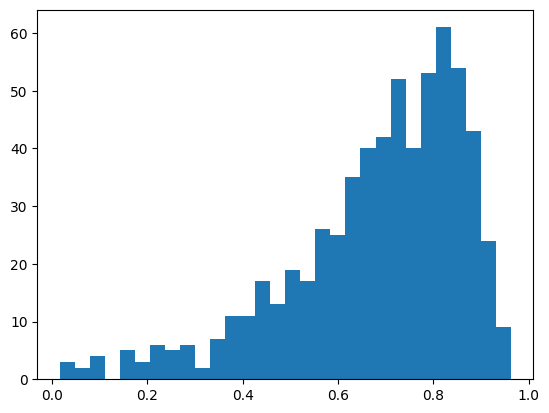

In [14]:
from matplotlib import pyplot as plt

plt.hist(calibrated_KGES[calibrated_KGES>0], bins = 30)
plt.show()

In [15]:
calibrated_KGES.mean()

0.6058311566899195

In [16]:
np.median(calibrated_KGES)

0.7101414821588832